# Машинное обучение, ВМК МГУ

## Практическое задание 4. Разложение ошибки на смещение и разброс. Градиентный бустинг ~~своими руками~~

### Общая информация

Дата выдачи: 30.11.2020 01:00

Мягкий дедлайн: 01:00MSK 14.12.2020

Жесткий дедлайн: 01:00MSK 21.12.2020

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-04-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston. 
Также в задании вам будет предложено пообучать готовые модели градиентного бустинга и CatBoost.

**Напоминание:**
    
* Все ваши графики должны быть **"красивыми"** --- подробнее о том, как их оформлять, можно найти в первом практическом задании. При несоответствии какиму-то из критериев вам могут снять баллы.
* Пишите в текстовых ячейках/print в коде ответы на **все вопросы из заданий/просьбы сделать выводы** --- при их отсутствии мы не можем понять, сделали ли вы задание и понимаете, что происходит, и поэтому будем снижать баллы

## Часть 1. Bias-Variance Decomposition

In [1]:
import numpy as np
import pandas as pd
import warnings
import tqdm.notebook as tqdm
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn import base, metrics, preprocessing, model_selection
from sklearn.datasets import load_boston

%matplotlib inline

In [2]:
boston = load_boston()

In [3]:
X = boston["data"]
y = boston["target"]

In [4]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [5]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.68720305555132

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__Задание 1. (1.5 баллa)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [6]:
def get_oob_preds(regressor, X, y, num_runs):
    oob_preds = np.full((num_runs, y.size), np.nan)

    for idx in tqdm.trange(num_runs, leave=False):
        bootstrap = np.random.choice(y.size, y.size)
        oob_set = np.arange(y.size)
        oob_set = oob_set[~np.isin(oob_set, bootstrap)]
        
        reg = base.clone(regressor)
        reg = reg.fit(X[bootstrap], y[bootstrap])
        
        oob_preds[idx, oob_set] = reg.predict(X[oob_set])
    
    return oob_preds


def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    oob_preds = get_oob_preds(regressor, X, y, num_runs)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message='Mean of empty slice', category=RuntimeWarning)
        
        bias = np.nanmean(oob_preds, axis=0) - y
        bias *= bias
        bias = np.nanmean(bias).item()
        
        variance = np.nanmean(oob_preds, axis=0) - oob_preds
        variance *= variance
        variance = np.nanmean(variance).item()

        error = oob_preds - y
        error *= error
        error = np.nanmean(error).item()
        
    return bias, variance, error

**Задание 2. (0.5 баллa)**

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.


In [7]:
from sklearn import linear_model, tree, ensemble

for model in [
    linear_model.LinearRegression,
    tree.DecisionTreeRegressor,
    ensemble.RandomForestRegressor,
]:
    bias, variance, error = compute_biase_variance(model(), X, y)
    print(f"{model.__name__:>21}: {bias=:>8.4f} {variance=:>8.4f} {error=:>8.4f}")

     LinearRegression: bias= 23.7239 variance=  0.9255 error= 24.6313


DecisionTreeRegressor: bias= 10.0435 variance= 13.1066 error= 23.1008


RandomForestRegressor: bias= 10.6499 variance=  2.2329 error= 12.8155


Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__
> Да, согласуются. Как и ожидалось, линейная регрессия имеет почти 0 variance, решающее дерево - среднее, а случайный лес позволяет понизить variance отдельных деревьев.

Вспомните во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__
> В теории при применении бутстрапа можно ожидать уменьшение разброса в N раз, где N - количество усредненных алгоритмов. С гиперпараметрами по умолчанию N=100. На деле уменьшение получается значительно меньше (тут порядка 6 раз), т.к. не выполняется условие на отсутствие корреляций в ответах алгоритмов.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__Задание 3. (1.5 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [8]:
def get_bagging_preds(regressor, X, y, X_test, num_runs=100):
    bagging_preds = np.zeros((num_runs, X_test.shape[0]))

    for idx in tqdm.trange(num_runs, leave=False):
        bootstrap = np.random.choice(y.size, y.size)
        
        reg = base.clone(regressor)
        reg = reg.fit(X[bootstrap], y[bootstrap])
        
        bagging_preds[idx] = reg.predict(X_test)
    
    return bagging_preds


def get_bagging_deltas(regressor, X, y, seed=0, num_runs=100, num_test_objects=10):
    train = np.ones(y.size, dtype=np.bool)
    test = np.random.default_rng(seed).choice(y.size, num_test_objects, replace=False)
    train[test] = 0
    
    bagging_preds = get_bagging_preds(regressor, X[train], y[train], X[test], num_runs)
    deltas = bagging_preds - y[test]
    return deltas

In [9]:
sns.set_theme()
def adjust_plot(figsize=(1, 1), dpi=1, dpi_skew=1):
    plt.rcParams['figure.dpi'] = 72 * dpi * dpi_skew
    plt.rcParams['figure.figsize'] = [v*a/dpi for v, a in zip([6.4, 4.8], figsize)]


def plot_deltas(ax, deltas, noise_scale=0.1, size=128, alpha=0.2, color='C0'):
    ax.axhline(0, color='black', zorder=1)
    p = np.arange(deltas.shape[-1])
    for x in range(deltas.shape[0]):
        d = deltas[x]
        n = noise_scale * np.random.randn(deltas.shape[-1])
        ax.scatter(p+n, d, alpha=alpha, color=color, linewidth=0, marker='.', s=size, zorder=2)
    
    ax.set_xticks(p)

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

In [10]:
deltas = []
for idx, mod in enumerate([
    linear_model.LinearRegression,
    tree.DecisionTreeRegressor,
    ensemble.RandomForestRegressor,
]):
    deltas.append((mod.__name__, get_bagging_deltas(mod(), X, y)))

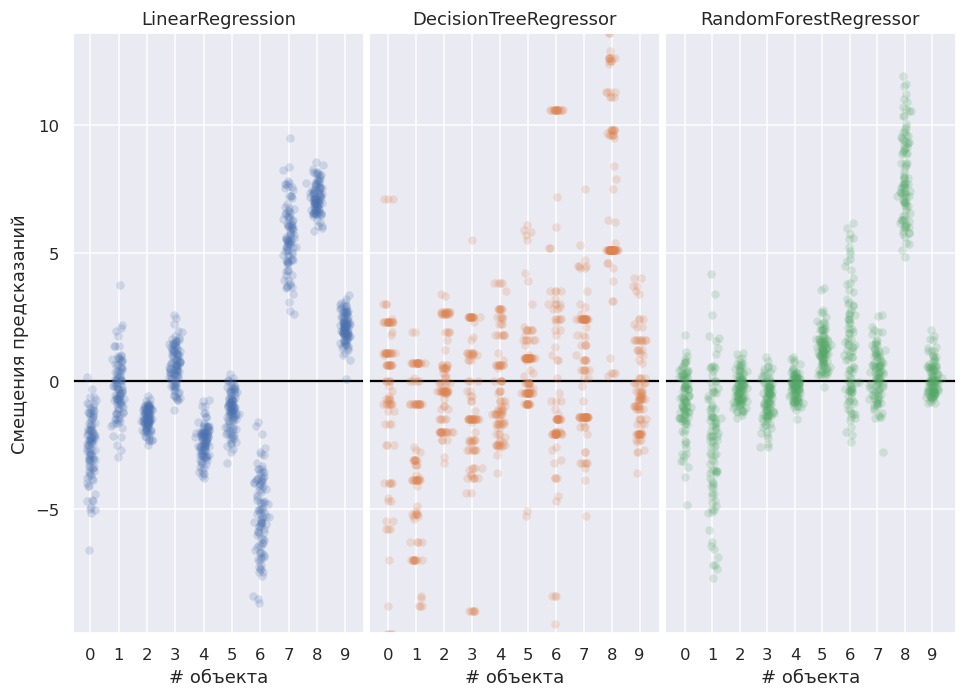

In [11]:
adjust_plot((2.47, 2.3), 1.5)
fig, axs = plt.subplots(1, 3)
fig.subplots_adjust(wspace=0.02)

lo, hi = np.quantile([d for _, d in deltas], 0.01), np.quantile([d for _, d in deltas], 0.99)
for idx, (ax, (name, delta)) in enumerate(zip(axs, deltas)):
    plot_deltas(ax, delta, color=f'C{idx}')
    ax.set_title(name)
    ax.set_ylim(lo - 2.5, hi + 2.5)
    ax.set_xlabel('# объекта')
    if idx:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Смещения предсказаний')

plt.show(fig)

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

**Your answer here:**
> Из графиков видно, что:
>    - линейная регрессия
>        - имеет маленький variance (точки в плотных группах)
>        - для некоторых объектов имеет большой, одинаково смещенный bias (вся группа точек далеко от 0)
>    - решающее дерево
>        - имеет большой variance (точки сильно разбросаны)
>        - почти все объекты имеют несмещенный bias (точки далеко от 0, но без явного смещения в какую-то сторону)
>    - случайный лес
>        - почти все объекты имеют маленький variance (точки в плотных группах)
>        - почти все объекты имеют маленький bias (вся группа точек близко к 0)
>
> Любопытно, что объект #8 имеет смещенные ответы даже для дерева/случайного леса. Возможно, это выброс или объект слишком сложный для выбранных моделей.

### Часть 2. Градиентный бустинг

**Задание 4 (1 балл)**

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869) (вам нужны только данные, посылать туда ничего не надо).
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы:
    * Воспользуйтесь описанием соревнования
    * При желании, воспользуйтесь методами feature selection/стат. методами, если хотите. Объясните, что использовали и почему решили выкинуть тот или иной признак.
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0. Если считаете нужным, сделайте сбалансированное по классам разбиение.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [12]:
data = pd.read_csv('hw-practice-4.data/application_train.csv')
y = data['TARGET']

In [13]:
X = data.drop(columns=['SK_ID_CURR', 'TARGET'])
X = X.dropna(axis=1)
cat_features = []
for c in X.columns:
    if X[c].dtype == np.object:
        X[c] = X[c].astype('category')
        cat_features.append(c)

> Я решил выкинуть все колонки, в которых есть `NaN` значения и `SK_ID_CURR`. Все остальные фичи я решил оставить для простоты.

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
prauc = metrics.average_precision_score

**Задание 5 (1 балл)**

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. **Получилась ли заметная разнциа в качестве? Как вы думаете, почему?**

**Замечание:**
* В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [15]:
import lightgbm.sklearn as lightgbm
import catboost

In [16]:
%%time
cat_mod = catboost.CatBoostClassifier(cat_features=[], task_type='GPU', devices='0:1', verbose=100)
cat_mod = cat_mod.fit(X_train.drop(columns=cat_features), y_train)

Learning rate set to 0.025585
0:	learn: 0.6667730	total: 4.83ms	remaining: 4.83s
100:	learn: 0.2723731	total: 349ms	remaining: 3.1s
200:	learn: 0.2688900	total: 666ms	remaining: 2.65s
300:	learn: 0.2676504	total: 999ms	remaining: 2.32s
400:	learn: 0.2665645	total: 1.43s	remaining: 2.14s
500:	learn: 0.2656003	total: 1.87s	remaining: 1.86s
600:	learn: 0.2645897	total: 2.19s	remaining: 1.45s
700:	learn: 0.2636232	total: 2.5s	remaining: 1.07s
800:	learn: 0.2627384	total: 2.82s	remaining: 700ms
900:	learn: 0.2618713	total: 3.13s	remaining: 344ms
999:	learn: 0.2609851	total: 3.45s	remaining: 0us
CPU times: user 5.52 s, sys: 1.48 s, total: 7 s
Wall time: 3.86 s


In [17]:
%%time
gbm_mod = lightgbm.LGBMClassifier() # device='gpu' <- I can't get lgbm to work with GPU :(
gbm_mod = gbm_mod.fit(X_train.drop(columns=cat_features), y_train)

CPU times: user 15.2 s, sys: 59.5 ms, total: 15.3 s
Wall time: 1.38 s


In [18]:
gbm_test_pred = gbm_mod.predict_proba(X_test.drop(columns=cat_features))[:, 1]
cat_test_pred = cat_mod.predict_proba(X_test.drop(columns=cat_features))[:, 1]

print(f'LightGBM: {prauc(y_test, gbm_test_pred):.3%}')
print(f'Catboost: {prauc(y_test, cat_test_pred):.3%}')

LightGBM: 14.668%
Catboost: 14.933%


**Your answer here:**
> Заметной разницы не получилось. Почему не знаю. Тут бустинг там бустинг, вроде и не должны сильно разные результаты получиться.

__Задание 6. (2 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Масштаб значений предлагается посмотреть [тут](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/seminars/sem10-gbm.ipynb).

**Проанализируйте соотношения получившихся оптимальных глубины и количества деревьев в зависимости от алгоритма.** 

**Если на перебор гиперпараметров уходит много времени, то переберите значениях каких-нибудь 1-2 гиперпараметров, а не всех предложенных 4**

In [19]:
%%time
gbm_mod_gcv = model_selection.GridSearchCV(
    lightgbm.LGBMClassifier(), 
    {
        'max_depth': np.arange(1, 12, 2),
        'n_estimators': np.logspace(0, 2.85, 5).round().astype(int),
    },
    scoring=metrics.make_scorer(prauc, needs_proba=True),
    cv=model_selection.StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
    verbose=True,
    n_jobs=-1,
)
gbm_mod_gcv = gbm_mod_gcv.fit(X_train.drop(columns=cat_features), y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   28.4s finished


CPU times: user 19 s, sys: 252 ms, total: 19.3 s
Wall time: 30.2 s


In [20]:
%%time
cat_mod_gcv = model_selection.GridSearchCV(
    catboost.CatBoostClassifier(cat_features=[], task_type='GPU', devices='0:1', verbose=False), 
    {
        'max_depth': np.arange(1, 12, 2),
        'n_estimators': np.logspace(0, 2.85, 5).round().astype(int),
    },
    scoring=metrics.make_scorer(prauc, needs_proba=True),
    cv=model_selection.StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
    verbose=True,
    # Don't use workers, since we are using GPU
    # n_jobs=-1,
)
cat_mod_gcv = cat_mod_gcv.fit(X_train.drop(columns=cat_features), y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.1min finished


CPU times: user 3min 26s, sys: 54.5 s, total: 4min 20s
Wall time: 2min 9s


In [21]:
gbm_test_pred = gbm_mod_gcv.predict_proba(X_test.drop(columns=cat_features))[:, 1]
cat_test_pred = cat_mod_gcv.predict_proba(X_test.drop(columns=cat_features))[:, 1]
print('           Test    Valid   Best Params')
print(f'LightGBM: {prauc(y_test, gbm_test_pred):.3%} {gbm_mod_gcv.best_score_:.3%} {gbm_mod_gcv.best_params_}')
print(f'Catboost: {prauc(y_test, cat_test_pred):.3%} {cat_mod_gcv.best_score_:.3%} {cat_mod_gcv.best_params_}')

           Test    Valid   Best Params
LightGBM: 14.926% 14.256% {'max_depth': 3, 'n_estimators': 708}
Catboost: 14.960% 14.214% {'max_depth': 5, 'n_estimators': 708}


**Your answer here:**
> Видимо на данной задаче отдельные деревья достаточно сильно переобучаются, т.к. оптимальные параметры для обоих алгоритмов имеют относительно маленькую глубину и максимальное количество деревьев.

**Задание 7 (1.5 баллa)**

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

Можно использовать библиотечные реализации; при подсчете счетчиков нельзя использовать циклы.

Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования? (Параметры можно не подбирать).

In [22]:
class Counter(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, C=0.0):
        self.C = C

    def _fit_single(self, x, y, uniq):
        vals = np.empty(uniq.size)
        for idx, u in enumerate(uniq):
            mask = x == u
            count = y[mask].sum() + self.C * self._global_mean
            norm = mask.sum() + self._global_mean
            vals[idx] = count/norm
        return vals
        
    def fit(self, X, y):
        self._global_mean = y.mean()
        self._cats = {c: np.sort(v.unique()) for c, v in X.items()}
        self._cats = {c: (self._cats[c], self._fit_single(v, y, self._cats[c])) for c, v in X.items()}
        return self

    def transform(self, X):
        X_vals = np.empty(X.shape)
        for cidx, (c, (uniq, vals)) in enumerate(self._cats.items()):
            X_c = X[c]
            X_uniq = X_c.unique()
            assert np.all(np.isin(X_uniq, uniq)), (c, X_uniq, uniq)
            for u, v in zip(uniq, vals):
                X_vals[X_c == u, cidx] = v
        return X_vals

In [23]:
ohe_features = []
cnt_features = []
for c in cat_features:
    for idx, ohe in enumerate(preprocessing.OneHotEncoder().fit_transform(X[[c]]).T):
        feat = 'ohe_' + c + '_' + str(idx)
        ohe_features.append(feat)
        X[feat] = ohe.toarray().squeeze(axis=0)
    
    cnt_features.append('cnt_' + c)
    X['cnt_' + c] = Counter(1.0).fit_transform(X[[c]], y)

In [24]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [25]:
%%time
cat_mod_ohe = catboost.CatBoostClassifier(cat_features=[], task_type='GPU', devices='0:1', verbose=100)
cat_mod_ohe = cat_mod_ohe.fit(X_train.drop(columns=cat_features + cnt_features), y_train)

Learning rate set to 0.025585
0:	learn: 0.6669010	total: 4.24ms	remaining: 4.24s
100:	learn: 0.2690911	total: 343ms	remaining: 3.05s
200:	learn: 0.2649025	total: 683ms	remaining: 2.72s
300:	learn: 0.2633739	total: 1.02s	remaining: 2.36s
400:	learn: 0.2621685	total: 1.41s	remaining: 2.1s
500:	learn: 0.2611073	total: 1.73s	remaining: 1.73s
600:	learn: 0.2600440	total: 2.07s	remaining: 1.37s
700:	learn: 0.2590522	total: 2.4s	remaining: 1.02s
800:	learn: 0.2581280	total: 2.73s	remaining: 679ms
900:	learn: 0.2571466	total: 3.06s	remaining: 337ms
999:	learn: 0.2562331	total: 3.4s	remaining: 0us
CPU times: user 5.9 s, sys: 1.38 s, total: 7.29 s
Wall time: 3.62 s


In [26]:
%%time
cat_mod_cnt = catboost.CatBoostClassifier(cat_features=[], task_type='GPU', devices='0:1', verbose=100)
cat_mod_cnt = cat_mod_cnt.fit(X_train.drop(columns=cat_features + ohe_features), y_train)

Learning rate set to 0.025585
0:	learn: 0.6663793	total: 3.75ms	remaining: 3.74s
100:	learn: 0.2685003	total: 340ms	remaining: 3.02s
200:	learn: 0.2643348	total: 677ms	remaining: 2.69s
300:	learn: 0.2627796	total: 1.02s	remaining: 2.36s
400:	learn: 0.2615882	total: 1.36s	remaining: 2.03s
500:	learn: 0.2604705	total: 1.7s	remaining: 1.69s
600:	learn: 0.2593704	total: 2.04s	remaining: 1.35s
700:	learn: 0.2583035	total: 2.38s	remaining: 1.01s
800:	learn: 0.2573323	total: 2.72s	remaining: 676ms
900:	learn: 0.2563809	total: 3.06s	remaining: 337ms
999:	learn: 0.2554472	total: 3.4s	remaining: 0us
CPU times: user 5.68 s, sys: 1.3 s, total: 6.98 s
Wall time: 3.6 s


In [27]:
%%time
gbm_mod_ohe = lightgbm.LGBMClassifier()
gbm_mod_ohe = gbm_mod_ohe.fit(X_train.drop(columns=cat_features + cnt_features), y_train)

CPU times: user 14.7 s, sys: 65.2 ms, total: 14.7 s
Wall time: 1.46 s


In [28]:
%%time
gbm_mod_cnt = lightgbm.LGBMClassifier()
gbm_mod_cnt = gbm_mod_cnt.fit(X_train.drop(columns=cat_features + ohe_features), y_train)

CPU times: user 6.1 s, sys: 11.2 ms, total: 6.11 s
Wall time: 605 ms


> Для Catboost, время обучения не меняется при добавлении OneHot или Counter признаков (я думаю, это связано с тем, что я использую GPU для Catboost и там изменение количества фич почти не меняет время обучения из-за параллелизма). Для LGBM, использование счетчиков ускоряет обучение.

**Задание 8 (1 балл)**

Для CatBoost можно не делать ручную обработку категориальных признаков, а подавать как есть. Обучите модель CatBoost, не обрабатывая специально категориальные признаки, замерьте время обучения (параметры возьмите из предыдущего пункта).  Сравните с временем обучения модели CatBoost из предыдущего пункта. Как изменилось время? Почему?

In [29]:
%%time
cat_mod_cat = catboost.CatBoostClassifier(cat_features=cat_features, task_type='GPU', devices='0:1', verbose=100)
cat_mod_cat = cat_mod_cat.fit(X_train.drop(columns=cnt_features + ohe_features), y_train)

Learning rate set to 0.025585
0:	learn: 0.6671251	total: 21.8ms	remaining: 21.8s
100:	learn: 0.2783445	total: 1.68s	remaining: 14.9s
200:	learn: 0.2708658	total: 3.51s	remaining: 13.9s
300:	learn: 0.2675393	total: 5.35s	remaining: 12.4s
400:	learn: 0.2656288	total: 7.22s	remaining: 10.8s
500:	learn: 0.2644656	total: 9.08s	remaining: 9.04s
600:	learn: 0.2634827	total: 10.9s	remaining: 7.23s
700:	learn: 0.2626693	total: 12.7s	remaining: 5.42s
800:	learn: 0.2619433	total: 14.5s	remaining: 3.6s
900:	learn: 0.2612884	total: 16.3s	remaining: 1.79s
999:	learn: 0.2606816	total: 18.2s	remaining: 0us
CPU times: user 28.9 s, sys: 2.15 s, total: 31 s
Wall time: 19 s


In [30]:
gbm_test_pred = gbm_mod.predict_proba(X_test.drop(columns=cat_features + ohe_features + cnt_features))[:, 1]
gbm_test_ohe_pred = gbm_mod_ohe.predict_proba(X_test.drop(columns=cat_features + cnt_features))[:, 1]
gbm_test_cnt_pred = gbm_mod_cnt.predict_proba(X_test.drop(columns=cat_features + ohe_features))[:, 1]

cat_test_pred = cat_mod.predict_proba(X_test.drop(columns=cat_features + ohe_features + cnt_features))[:, 1]
cat_test_ohe_pred = cat_mod_ohe.predict_proba(X_test.drop(columns=cat_features + cnt_features))[:, 1]
cat_test_cnt_pred = cat_mod_cnt.predict_proba(X_test.drop(columns=cat_features + ohe_features))[:, 1]
cat_test_cat_pred = cat_mod_cat.predict_proba(X_test.drop(columns=cnt_features + ohe_features))[:, 1]

print(f'LightGBM          : {prauc(y_test, gbm_test_pred):.3%}')
print(f'LightGBM  (OneHot): {prauc(y_test, gbm_test_ohe_pred):.3%}')
print(f'LightGBM (Counter): {prauc(y_test, gbm_test_cnt_pred):.3%}')
print()
print(f'Catboost          : {prauc(y_test, cat_test_pred):.3%}')
print(f'Catboost  (OneHot): {prauc(y_test, cat_test_ohe_pred):.3%}')
print(f'Catboost (Counter): {prauc(y_test, cat_test_cnt_pred):.3%}')
print(f'Catboost  (Native): {prauc(y_test, cat_test_cat_pred):.3%}')

LightGBM          : 14.668%
LightGBM  (OneHot): 15.921%
LightGBM (Counter): 16.066%

Catboost          : 14.933%
Catboost  (OneHot): 16.214%
Catboost (Counter): 16.224%
Catboost  (Native): 15.495%


> Я вообще понятия не имею, что тут происходит в плане времени обучения. Встроенные Catboost категориальные признаки почему-то работают медленнее и хуже чем OneHot/Counter хотя вроде как в документации Catboost обещают ровно обратного эффекта. Мистика.

**Бонус. (1 балл)**

Подберите оптимальные параметры для LightGBM с вещественными и категориальными признаками (предварительно обработанные каким-нибудь способом). Подберите оптимальные параметры для CatBoost с вещественными и необработанными категориальными признаками. Сравните качество моделей на наилучших параметрах. Какой метод получился лучше с точки зрения качества? Совпадает ли результат с вашими ожиданиями?

In [31]:
%%time
gbm_mod_cnt_gcv = model_selection.GridSearchCV(
    lightgbm.LGBMClassifier(), 
    {
        'max_depth': np.arange(1, 12, 2),
        'n_estimators': np.logspace(0, 2.85, 5).round().astype(int),
    },
    scoring=metrics.make_scorer(prauc, needs_proba=True),
    cv=model_selection.StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
    verbose=True,
    n_jobs=-1,
)
gbm_mod_cnt_gcv = gbm_mod_cnt_gcv.fit(X_train.drop(columns=cat_features + ohe_features), y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   34.9s finished


CPU times: user 21.7 s, sys: 164 ms, total: 21.8 s
Wall time: 36.9 s


In [32]:
%%time
cat_mod_cat_gcv = model_selection.GridSearchCV(
    catboost.CatBoostClassifier(cat_features=cat_features, task_type='GPU', devices='0:1', verbose=False), 
    {
        'max_depth': np.arange(1, 12, 2),
        'n_estimators': np.logspace(0, 2.85, 5).round().astype(int),
    },
    scoring=metrics.make_scorer(prauc, needs_proba=True),
    cv=model_selection.StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
    verbose=True,
    # Don't use workers, since we are using GPU
    # n_jobs=-1,
)
cat_mod_cat_gcv = cat_mod_cat_gcv.fit(X_train.drop(columns=cnt_features + ohe_features), y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  8.4min finished


CPU times: user 11min 39s, sys: 50.8 s, total: 12min 29s
Wall time: 8min 24s


In [33]:
gbm_test_pred = gbm_mod_gcv.predict_proba(X_test.drop(columns=cat_features + ohe_features + cnt_features))[:, 1]
cat_test_pred = cat_mod_gcv.predict_proba(X_test.drop(columns=cat_features + ohe_features + cnt_features))[:, 1]
gbm_test_cnt_pred = gbm_mod_cnt_gcv.predict_proba(X_test.drop(columns=cat_features + ohe_features))[:, 1]
cat_test_cat_pred = cat_mod_cat_gcv.predict_proba(X_test.drop(columns=cnt_features + ohe_features))[:, 1]

print('                     Test    Valid   Best Params')
print(f'LightGBM          : {prauc(y_test, gbm_test_pred):.3%} {gbm_mod_gcv.best_score_:.3%} {gbm_mod_gcv.best_params_}')
print(f'Catboost          : {prauc(y_test, cat_test_pred):.3%} {cat_mod_gcv.best_score_:.3%} {cat_mod_gcv.best_params_}')
print()
print(f'LightGBM (Counter): {prauc(y_test, gbm_test_cnt_pred):.3%} {gbm_mod_cnt_gcv.best_score_:.3%} {gbm_mod_cnt_gcv.best_params_}')
print(f'Catboost  (Native): {prauc(y_test, cat_test_cat_pred):.3%} {cat_mod_cat_gcv.best_score_:.3%} {cat_mod_cat_gcv.best_params_}')

                     Test    Valid   Best Params
LightGBM          : 14.926% 14.256% {'max_depth': 3, 'n_estimators': 708}
Catboost          : 14.960% 14.214% {'max_depth': 5, 'n_estimators': 708}

LightGBM (Counter): 16.353% 15.964% {'max_depth': 3, 'n_estimators': 708}
Catboost  (Native): 16.176% 15.825% {'max_depth': 5, 'n_estimators': 137}


> Лучшим получился метод LightGBM со счетчиками (да да, я сам в шоке, это вроде первое задание, где счетчики не сильно хуже)
>
> Результат "совпадает" с моими ожиданиями, т.к. я ничего не ожидал. :)

**Бонус (0.2 балла)**

Вставьте лучший мем 2020

<img src="https://i.ibb.co/qjZ2kPB/counters.png" border="0">